In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# data read 
words = open('/home/risal/X3s4c5/Makemore/names.txt','r').read().splitlines()

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [5]:
# Data components 
def build_dataset(words):
    X, Y= [] , []
    block_size = 3
    
    for w in words:
        context  = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

import random
random.seed(42)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_trn, Y_trn = build_dataset(words[:n1])
X_dev, Y_dev = build_dataset(words[n1:n2])
X_tst, Y_tst = build_dataset(words[n2:])

In [6]:
X_trn.shape, X_dev.shape, X_tst.shape

(torch.Size([182778, 3]), torch.Size([22633, 3]), torch.Size([22735, 3]))

In [18]:
n1, n2

(25626, 28829)

In [19]:
X.shape, Y.shape, len(words)

NameError: name 'X' is not defined

In [20]:
# creating the embedding look up table 
C = torch.randn((27,2))

In [21]:
emb = C[X]
emb.shape

NameError: name 'X' is not defined

In [22]:
W1 = torch.rand((6,100))
b1 = torch.randn(100) 

In [23]:
torch.cat([emb[: ,0 , :], emb[: ,1 , :], emb[: ,2 , :]], dim = 1).shape, W1.shape

NameError: name 'emb' is not defined

In [245]:
h = torch.tanh(emb.view((-1,6)) @ W1 + b1)

In [246]:
h.shape

torch.Size([228146, 100])

In [247]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)
logits = h @ W2 + b2
logits.shape

torch.Size([228146, 27])

In [248]:
counts = logits.exp()
counts.shape

torch.Size([228146, 27])

In [249]:
probs = counts / counts.sum(1, keepdims = True)
probs.shape

torch.Size([228146, 27])

In [251]:
loss = -probs[torch.arange(X.shape[0]), Y].log().mean()

In [252]:
loss

tensor(17.9299)

In [253]:
torch.arange(32)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [50]:
# Defining 
X_trn.shape, Y_trn.shape

(torch.Size([182778, 3]), torch.Size([182778]))

In [234]:
g = torch.Generator().manual_seed(123)
C = torch.randn((27,10), generator = g) # embedding lookup table 10 -> embedding size
W1 = torch.randn((30, 200), generator = g)
b1 = torch.randn(200, generator = g)
W2 = torch.randn((200,27), generator = g)
b2 = torch.randn(27, generator = g)
parameters = [W1, b1, W2, b2]

In [235]:
sum(p.nelement() for p in parameters)

11627

In [236]:
for p in parameters:
    p.requires_grad = True

In [237]:
lre = torch.linspace(-3,0, 1000)
lrs = 10**lre

In [238]:
losses = []
lrt =[]
for i in range(1000):
    # mini batch
    ix = torch.randint(0,X_trn.shape[0], (128,))
    # forward passes 
    emb = C[X_trn[ix]] # [32, 4, 2]
    h = torch.tanh(emb.view((-1,30)) @ W1 + b1)  # [32, 100]
    logits = h @ W2 + b2 #  [32, 27]
    # counts = logits.exp()
    # probs = counts / counts.sum(1, keepdims = True)
    # loss = -probs[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits,  Y_trn[ix]) 

    # backward pass 
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update params 
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad

    #track stats 
    lrt.append(lre[i])
    losses.append(loss.item())

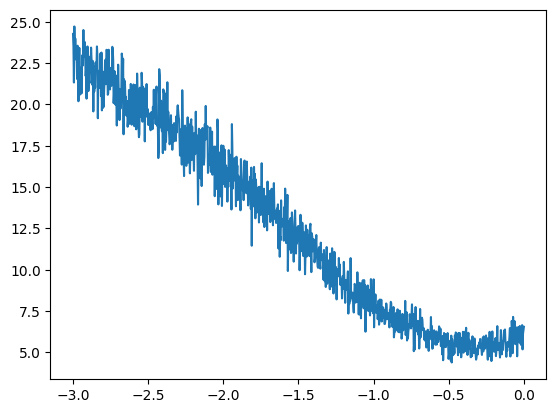

In [239]:
plt.plot(lrt, losses)

In [240]:
losses_train = []
step_i = []

In [241]:
for i in range(30000):
    # mini batch
    ix = torch.randint(0,X_trn.shape[0], (128,))
    # forward passes 
    emb = C[X_trn[ix]] # [32, 4, 2]
    h = torch.tanh(emb.view((-1,30)) @ W1 + b1)  # [32, 100]
    logits = h @ W2 + b2 #  [32, 27]
    loss = F.cross_entropy(logits,  Y_trn[ix]) 

    # backward pass 
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update params
    if i <= 20000: 
        lr = 0.4 
    else: 
        lr = 0.1
    # lr = 0.1 # use initial lr as 0.25 and decay lr as 0.1
    for p in parameters:
        p.data += -lr * p.grad

    # track stats 
    if i % 1000 == 0:
        print(f"{i:7d} : {loss.item():.4f}")
    losses_train.append(loss.item())
    step_i.append(step_i)
loss.item()

      0 : 8.3039
   1000 : 3.2086
   2000 : 2.1081
   3000 : 2.8884
   4000 : 2.4258
   5000 : 2.6106
   6000 : 2.1589
   7000 : 2.3287
   8000 : 2.3933
   9000 : 2.2164
  10000 : 2.2007
  11000 : 2.4462
  12000 : 2.1284
  13000 : 2.4352
  14000 : 2.2676
  15000 : 2.2691
  16000 : 2.2663
  17000 : 2.2607
  18000 : 2.1791
  19000 : 2.0641
  20000 : 2.1100
  21000 : 1.9658
  22000 : 1.9823
  23000 : 2.0846
  24000 : 2.0452
  25000 : 1.9971
  26000 : 1.9858
  27000 : 2.0004
  28000 : 2.0752
  29000 : 1.7829


2.017688751220703

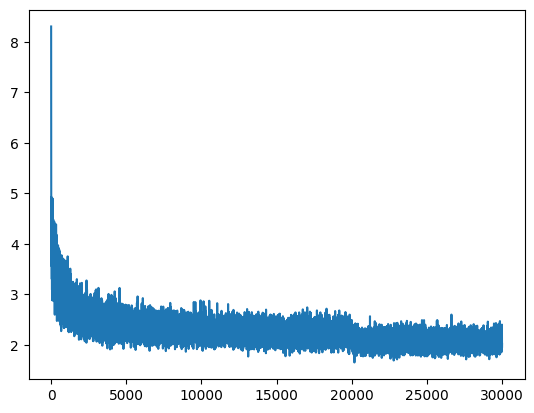

In [242]:
plt.plot(losses_train)

In [243]:
emb = C[X_dev] # [32, 4, 2]
h = torch.tanh(emb.view((-1,30)) @ W1 + b1)  # [32, 100
logits = h @ W2 + b2 #  [32, 27]
loss = F.cross_entropy(logits,  Y_dev) 
loss

tensor(2.4326, grad_fn=<NllLossBackward0>)

In [244]:
emb = C[X_trn] # [32, 4, 2]
h = torch.tanh(emb.view((-1,30)) @ W1 + b1)  # [32, 100
logits = h @ W2 + b2 #  [32, 27]
loss = F.cross_entropy(logits,  Y_trn) 
loss

tensor(2.0691, grad_fn=<NllLossBackward0>)

In [245]:
emb = C[X_tst] # [32, 4, 2]
h = torch.tanh(emb.view((-1,30)) @ W1 + b1)  # [32, 100
logits = h @ W2 + b2 #  [32, 27]
loss = F.cross_entropy(logits,  Y_tst) 
loss

tensor(2.4714, grad_fn=<NllLossBackward0>)

In [246]:
C[torch.tensor([[0] * block_size])]

tensor([[[ 0.3374, -0.1778, -0.3035, -0.5880,  0.3486,  0.6603, -0.2196,
          -0.3792,  0.7671, -1.1925],
         [ 0.3374, -0.1778, -0.3035, -0.5880,  0.3486,  0.6603, -0.2196,
          -0.3792,  0.7671, -1.1925],
         [ 0.3374, -0.1778, -0.3035, -0.5880,  0.3486,  0.6603, -0.2196,
          -0.3792,  0.7671, -1.1925]]])

In [247]:
g  = torch.Generator().manual_seed(123)
block_size = 3
for i in range(1):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        embcat = emb.view((emb.shape[0], -1))
        h = torch.tanh(embcat @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim = 1)

        ix = torch.multinomial(probs, num_samples = 1, replacement = True, generator = g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

aslanajaahktaslmskknrjpyjdjyyakisaacerrdmahahafkscleapdmuckmhbazcmlkdgehpcaglasbsbsdsghjsakncjnrijahegjzkcmmjaasbnakkcmmethgabclkdncxsissslkkjsmhhdjnahdmjdcnlbgahacismaenmaaahritaaeazcjmpgdceecsaasakljeksmrdtelskjnjeimmplhashkgmcdnkidzkkrsbceymmdsbyalmkltddkkhadyamrjksrbtantakajjanmashatjrcjkafbhdzmgckbkantyhahkdkjsyyatcdawrtkamlnhssfbmsamimssrslcldshabcepgynsnbbgjgdvdafahszsnraamaslmaerapamrhdmryaamcrrkszsmjgsalhzmsambkmsemjtpfbhsykajgpryvnnbdnhmsasbafhsartsaminmaehsajkacessdtlrkiepkbrmhslrmrmqbmmpmsgrknktgsakpnyjaskesgnhavobakkalaspaimaaegasblktasmflhhkseycesszektdageppmkecamdtgomasjmsmhmaabsalmokkekslcmrsamashdflrpdemmjaesdznamruarbfdcclhmnyyybakjhbdekeleeagldmsaztkrlhsgjmlermlkblygllejedsushhetjdknsarsgankrabifkidbealfeahzfgxmjtjglttbnmavbbacpyaelmkpbnakaatsimslnasmihsfezhljaadbhcjtsbkskoabsbamsjaptaekrlkmgnslphntssjnkmbspyscyaltknaznsphaaowaanjhdkarenkhhassfecjfrrtbhabdlipjsrashbcmmamcabegamxpjytaerkkdjcstjemhabgltmkyclansnndlskaecagskaossnhernmmlsskfebkhjarddebmvaphskpsrahlhinlas